In [1]:
import pandas as pd 
import numpy as np

code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0] 
# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) 
# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 
code_df = code_df[['회사명', '종목코드']] 
# 한글로된 컬럼명을 영어로 바꿔준다. 
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'}) 

code_df.head()

,name,code
0,DSR,155660
1,GS,078930
2,GS글로벌,001250
3,HDC현대산업개발,294870
4,LG이노텍,011070


In [3]:
time = '20200507174034'

def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False).lstrip() 
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    print("요청 URL = {}".format(url))
    return url 
# 신라젠의 일자데이터 url 가져오기 
item_name='아이씨케이'
url = get_url(item_name, code_df) 
# 일자 데이터를 담을 df라는 DataFrame 정의 
df = pd.DataFrame() 
# 1페이지에서 20페이지의 데이터만 가져오기 
for page in range(1, 61): 
    pg_url = '{url}&page={page}'.format(url=url, page=page) 
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True) 
    
# df.dropna()를 이용해 결측값 있는 행 제거 
df = df.dropna() 
# 상위 5개 데이터 확인하기 


df

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=068940


,날짜,종가,전일비,시가,고가,저가,거래량
1,2020.05.29,3230.0,350.0,2880.0,3300.0,2820.0,2841871.0
2,2020.05.28,2880.0,100.0,2980.0,3065.0,2810.0,699235.0
3,2020.05.27,2980.0,150.0,3140.0,3180.0,2830.0,1085486.0
4,2020.05.26,3130.0,30.0,3150.0,3220.0,3070.0,689088.0
5,2020.05.25,3160.0,65.0,3115.0,3225.0,3050.0,1052651.0
...,...,...,...,...,...,...,...
894,2017.12.21,2385.0,120.0,2245.0,2390.0,2200.0,752716.0
895,2017.12.20,2265.0,15.0,2300.0,2355.0,2110.0,1134439.0
896,2017.12.19,2280.0,270.0,2490.0,2520.0,2260.0,1645728.0
897,2017.12.18,2550.0,220.0,2325.0,2730.0,2325.0,3002545.0


In [9]:

#df[''] = [x + ':00' for x in df['체결시각']df['날짜'] = [x + ':00' for x in df['체결시각']짜#f['날짜'] = [x + ':00' for x in df['체결시각']df['날짜'] = [x + ':00' for x in df['체결시각']짜#]
df['날짜'] = pd.to_timedelta(df['날짜'], unit='s')

df = df.sort_values(by=['체결시각'], ascending=True)

df

ValueError: no units specified

In [149]:
df.to_csv('sg.csv', mode = 'w')

In [8]:
df2 = pd.DataFrame({'날짜' : pd.date_range(start='2018-01-01', end='2020-04-30', freq='D')})
df2

,날짜
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
846,2020-04-26
847,2020-04-27
848,2020-04-28
849,2020-04-29


In [255]:
new_df = df2.join(df.set_index('날짜'), on='날짜').drop_duplicates(keep='last')
new_df = new_df.fillna(method='ffill')
new_df

In [269]:
from sklearn.preprocessing import MinMaxScaler

new_df.to_csv('sg.csv', mode = 'w')

data = new_df.iloc[:,1:2].astype('float32').to_numpy()
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
x_train = []
#for i in range(0,300,10):
    #x_train = np.hstack[]
y_train = []
#[data[i+90:i+100] for i in range(4)]
for i in range(0,301,10):
    x_train.append(data[i:100+i,:].tolist())
    y_train.append(data[90+i:100+i,0])

y_train = np.array(y_train)
#y_train = scaler.fit_transform
x_train = np.array(x_train)
#x_train = scaler.fit_transform(x_train)
#x_train = np.expand_dims(x_train, axis=2)
x_train.shape, y_train.shape

((31, 100, 1), (31, 10))

In [273]:
x_test = data[len(data)-100:]
x_test = np.expand_dims(x_test, axis=0)
y_test = data[len(data)-10:,0]
y_test = np.expand_dims(y_test, axis=0)
x_test.shape, y_test.shape

((1, 100, 1), (1, 10))

In [288]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import np_utils

# Create the model
model = Sequential()
model.add(Conv1D(64, 2, input_shape = (x_train.shape[1],x_train.shape[2]), activation='relu'))
model.add(Conv1D(64, 2, activation='relu'))
#model.add(Dropout(0.2))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation='relu'))
# Compile model
epochs = 10
batch_size = 30
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])
model.summary()

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

scores = model.evaluate(x_test, y_test, verbose=0)

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_193 (Conv1D)          (None, 99, 64)            192       
_________________________________________________________________
conv1d_194 (Conv1D)          (None, 98, 64)            8256      
_________________________________________________________________
flatten_39 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_118 (Dense)            (None, 1000)              6273000   
_________________________________________________________________
dense_119 (Dense)            (None, 100)               100100    
_________________________________________________________________
dense_120 (Dense)            (None, 10)                1010      
Total params: 6,382,558
Trainable params: 6,382,558
Non-trainable params: 0
___________________________________________

[0.011581650003790855, 0.011581650003790855]


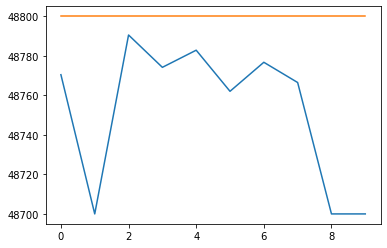

In [290]:
import matplotlib.pyplot as plt

print(scores)
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_real = scaler.inverse_transform(y_test)
plt.plot(np.arange(0,10), y_pred[0,:])
plt.plot(np.arange(0,10), y_real[0,:])